In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.linalg import sqrtm
import math
d=3

# 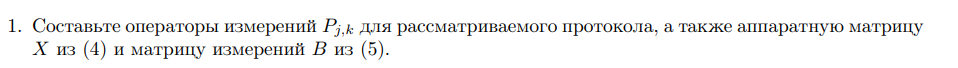

In [2]:
w=np.exp(1j*2*np.pi/d)
A0=np.array([[1,0,0],[0,1,0],[0,0,1]])
A1=np.array([[1,1,1],[1,w,w**2],[1,w**2,w]])/np.sqrt(3)
A2=np.array([[1,1,1],[w,w**2,1],[w,1,w**2]])/np.sqrt(3)
A3=np.array([[1,1,1],[w**2,w,1],[w**2,1,w]])/np.sqrt(3)
A=np.array([A0,A1,A2,A3])


A_projectors=np.array([
    np.array([
        A[j].T[i].reshape((d,1))@(A[j].T[i].reshape((d,1)).T.conjugate())
        for i in range(d)])
    for j in range(d+1)])

B=np.array([
    np.array([
        A_projectors[i][j].reshape(-1)
        for j in range(d)])
    for i in range(d+1)]).reshape((d**2+d,d**2))

X=np.array([
    np.array([
        (A[j].T[i].reshape((d,1)).T.conjugate())[0]
        for i in range(d)])
    for j in range(d+1)]).reshape((d**2+d,d))

# 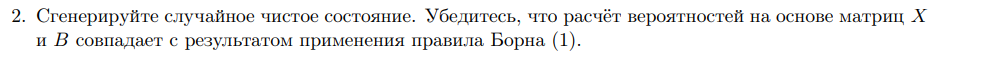

In [3]:
def get_psi(d=d):
    psi = np.reshape(np.array([np.random.normal() for i in range(d)]) + 1j*np.array([np.random.normal() for i in range(d)]), (d,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    return psi

psi=get_psi()

In [4]:
rho=psi@(psi.T.conjugate())
rho_column=(psi@(psi.T.conjugate())).T.reshape((d**2,1))
M=X@psi

P=np.real(B@rho_column)


p_M=np.abs(M)**2

p_Born=np.real(np.array([
    np.array([
        np.trace(A_projectors[i][j]@rho) for j in range(d)
    ]) for i in range(d+1)
])).reshape((d*d+d,1))

In [5]:
print("closeness")
print("M")
print(np.linalg.norm(p_M-p_Born))
print("B")
print(np.linalg.norm(P-p_Born))

closeness
M
4.130827920317053e-16
B
1.3018518929051675e-16


In [6]:
print("Born")
print(p_Born)
print("M")
print(p_M)
print("B")
print(P)


Born
[[0.73310434]
 [0.18321035]
 [0.08368531]
 [0.26616269]
 [0.65914523]
 [0.07469208]
 [0.33132257]
 [0.29828877]
 [0.37038866]
 [0.16453266]
 [0.73323518]
 [0.10223215]]
M
[[0.73310434]
 [0.18321035]
 [0.08368531]
 [0.26616269]
 [0.65914523]
 [0.07469208]
 [0.33132257]
 [0.29828877]
 [0.37038866]
 [0.16453266]
 [0.73323518]
 [0.10223215]]
B
[[0.73310434]
 [0.18321035]
 [0.08368531]
 [0.26616269]
 [0.65914523]
 [0.07469208]
 [0.33132257]
 [0.29828877]
 [0.37038866]
 [0.16453266]
 [0.73323518]
 [0.10223215]]


# 

In [7]:
gamma=0.1
def depolarizing_noise(rho,gamma):
    return (1-gamma)*rho+gamma*np.eye(d,dtype=complex)/d
rho_noise=depolarizing_noise(rho,gamma)

# 
# 
# 

In [8]:
counts=10
def masurement(rho,A_projectors=A_projectors,counts=counts):
    p_Born=np.real(np.array([
    np.array([
        np.trace(A_projectors[i][j]@rho) for j in range(d)
    ]) for i in range(d+1)
]))
    return np.array([
        np.random.multinomial(counts, p_Born[i], size=1)
        for i in range(d+1)]).reshape((d**2+d,1))/counts

In [9]:
p=masurement(rho_noise)
print(p)

[[0.7]
 [0.2]
 [0.1]
 [0.4]
 [0.6]
 [0. ]
 [0.3]
 [0.4]
 [0.3]
 [0.2]
 [0.7]
 [0.1]]


In [10]:
u,s,v=np.linalg.svd(B)
q=u.T.conjugate()@p
f=np.array([q[j]/s[j] for j in range(d**2)])
rho_reconstruct=(v.T.conjugate()@f).reshape((d,d)).T    

def Fidelity(a,b):
    return np.real(np.trace(sqrtm(sqrtm(b)@a@sqrtm(b)))**2)
print("Fidelity = "+str(Fidelity(rho_reconstruct,rho_noise)))

def delta_determination(rho_reconstruct):
    value,vec=np.linalg.eigh(rho_reconstruct)
    return np.abs(value[value<0]).sum()
delta=delta_determination(rho_reconstruct)
print("delta = "+str(delta))

Fidelity = 1.0147611116813573
delta = 0.09607713395018845


# 

In [11]:
def reconstruction(p,u=u,s=s,v=v,projection=False): #from Lab 2 p=counts
    if projection==False:
        q=u.T.conjugate()@p
        f=np.array([q[j]/s[j] for j in range(d**2)])
        return (v.T.conjugate()@f).reshape((d,d)).T
    else:
        q=u.T.conjugate()@p
        f=np.array([q[j]/s[j] for j in range(d**2)])
        rho=(v.T.conjugate()@f).reshape((d,d)).T

        val, vec=np.linalg.eigh(rho)
        val=np.round(val[::-1],10)
        vec=np.array([(vec.T[::-1])[i] for i in range(0,d)],dtype=complex).T
        
        omega=np.real(np.array([(val[:i+1:].sum()-1)/(i+1) for i in range(d)]))
        val_omega=np.array([val[i]-omega[i] for i in range(d)])
        j0=len(val_omega[val_omega>0])
        omega_0=omega[j0-1]
        val1=np.array([val[i]-omega_0 for i in range(j0)]+[0 for i in range(d-j0)])
         

        rhotest=vec@np.diag(val1)@(vec.T.conjugate())
        return rhotest 

In [12]:
%%time
N_mean=100
N_gamma=50
N=np.array([10,100,1000])
gamma_samples=np.linspace(0,1,N_gamma)
delta_mean=np.zeros((3,50))
for shots in range(len(N)):
    for g in range(len(gamma_samples)):
        rho_temp=depolarizing_noise(rho,gamma_samples[g])
        delta_samples=np.array([])
        for j in range(N_mean):
            p=masurement(rho_temp,A_projectors=A_projectors,counts=N[shots])
            rho_rebuild=reconstruction(p,u=u,s=s,v=v,projection=False)
            delta_samples=np.append(delta_samples,delta_determination(rho_rebuild))
        delta_mean[shots][g]=delta_samples.mean()

Wall time: 5.3 s


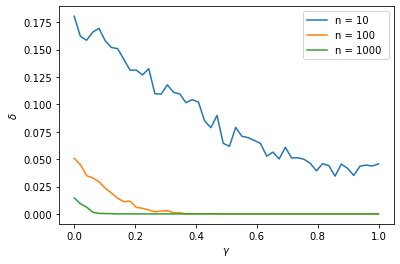

In [13]:
plt.plot(gamma_samples,delta_mean[0])
plt.plot(gamma_samples,delta_mean[1])
plt.plot(gamma_samples,delta_mean[2])
plt.legend(["n = 10","n = 100","n = 1000 "])
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\delta$")
plt.show()

# 

In [14]:
N_samples=100
gamma=0
fidelity_samples=np.array([])
for i in range(N_samples):
    p=masurement(rho_noise,A_projectors=A_projectors,counts=N_samples)
    rho_rebuild=reconstruction(p,u=u,s=s,v=v,projection=True)
    fidelity_samples=np.append(fidelity_samples,Fidelity(rho_rebuild,rho_noise))    

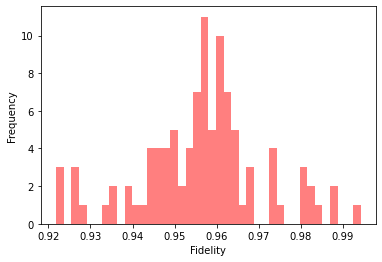

In [15]:
plt.hist(fidelity_samples, bins=40, color='red', alpha=0.5, label='mix')
plt.xlabel("Fidelity")
plt.ylabel("Frequency")
plt.show()